# O PROBLEMA

Imagine que você foi escalado para um time de investimentos e precisará realizar um modelo preditivo com dados do IBOVESPA (Bolsa de Valores) para criar uma série temporal e prever diariamente o fechamento da base.

Para isso, utilize a base de dados contida no site da investing e selecione o período 'diário', com intervalo de tempo que achar adequado.

Você precisará demonstrar para o time de investimentos:

1. O modelo com storytelling, desde a captura do dado até a entrega do modelo;
2. Justificar a técnica utilizada;
3. Atingir uma acurácia adequada (acima de 70%).

Dica: utilize o maior intervalo de tempo possível para atingir maior acurácia no modelo preditivo.

Fonte: https://br.investing.com/indices/bovespa-historical-data

## Importando bibliotecas

In [439]:
import warnings 
warnings.filterwarnings(action = 'ignore')

In [440]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Importando dados

In [441]:
df = pd.read_csv('Dados Históricos - Ibovespa.csv')

In [442]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2478 entries, 0 to 2477
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Data      2478 non-null   object 
 1   Último    2478 non-null   float64
 2   Abertura  2478 non-null   float64
 3   Máxima    2478 non-null   float64
 4   Mínima    2478 non-null   float64
 5   Vol.      2477 non-null   object 
 6   Var%      2478 non-null   object 
dtypes: float64(4), object(3)
memory usage: 135.6+ KB


In [443]:
df.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,08.08.2023,119.090,119.378,119.553,117.492,"10,25M","-0,24%"
1,07.08.2023,119.380,119.509,120.104,118.894,"8,73M","-0,11%"
2,04.08.2023,119.508,120.586,121.442,119.215,"15,07M","-0,89%"
3,03.08.2023,120.586,120.859,122.619,120.365,"13,03M","-0,23%"
4,02.08.2023,120.859,121.249,121.252,119.798,"10,57M","-0,32%"


## Tratamento de dados

In [444]:
#verificando ocorrência de dados nulos
df.isna().sum()

Data        0
Último      0
Abertura    0
Máxima      0
Mínima      0
Vol.        1
Var%        0
dtype: int64

In [445]:
df[df['Vol.'].isnull()]

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
1860,10.02.2016,40.377,40.592,40.592,39.96,NaN,"-0,53%"


In [446]:
df.drop(1860, inplace = True)
df.isna().sum()

Data        0
Último      0
Abertura    0
Máxima      0
Mínima      0
Vol.        0
Var%        0
dtype: int64

In [447]:
#verificando valores duplicados
df.duplicated().sum()

0

In [448]:
#verificando ocorrência de espaçamentos
espacamento_encontrado = False

for column in df.columns:
    for index, value in df[column].items():
        if isinstance(value, str) and value.isspace():
            print(f'Espaçamento encontrado na coluna "{column}", linha {index}.')
            espacamento_encontrado = True

if not espacamento_encontrado:
    print('Não há espaçamento nos dados.')

Não há espaçamento nos dados.


In [449]:
#renomeando colunas
df.rename(columns = {
    'Data': 'data', 
    'Último': 'ultimo', 
    'Abertura': 'abertura', 
    'Máxima': 'maxima', 
    'Mínima': 'minima', 
    'Vol.': 'volume', 
    'Var%': 
    'variacao'}, inplace = True)
df.columns

Index(['data', 'ultimo', 'abertura', 'maxima', 'minima', 'volume', 'variacao'], dtype='object')

In [450]:
#alterando tipo da coluna de data
df['volume'] = df['volume'].str.replace(',', '.')
df['volume'] = df['volume'].str.replace('K', '')
df['volume'] = df['volume'].str.replace('M', '').astype(float)
df['variacao'] = df['variacao'].str.replace(',', '.')
df['variacao'] = df['variacao'].str.replace('%', '').astype(float)
df['data'] = df['data'].str.replace('.', '-')
df['data'] = pd.to_datetime(df['data'], format='%d-%m-%Y')

In [451]:
df.head(3)

,data,ultimo,abertura,maxima,minima,volume,variacao
0,2023-08-08,119.090,119.378,119.553,117.492,10.25,-0.24
1,2023-08-07,119.380,119.509,120.104,118.894,8.73,-0.11
2,2023-08-04,119.508,120.586,121.442,119.215,15.07,-0.89


In [452]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2477 entries, 0 to 2477
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   data      2477 non-null   datetime64[ns]
 1   ultimo    2477 non-null   float64       
 2   abertura  2477 non-null   float64       
 3   maxima    2477 non-null   float64       
 4   minima    2477 non-null   float64       
 5   volume    2477 non-null   float64       
 6   variacao  2477 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 154.8 KB


In [453]:
df.set_index('data', inplace = True)
df.head()

,ultimo,abertura,maxima,minima,volume,variacao
data,,,,,,
2023-08-08,119.090,119.378,119.553,117.492,10.25,-0.24
2023-08-07,119.380,119.509,120.104,118.894,8.73,-0.11
2023-08-04,119.508,120.586,121.442,119.215,15.07,-0.89
2023-08-03,120.586,120.859,122.619,120.365,13.03,-0.23
2023-08-02,120.859,121.249,121.252,119.798,10.57,-0.32


In [454]:
df_fechamento_pontos = df['ultimo'].to_frame(name = 'ultimo')
df_fechamento_pontos

,ultimo
data,
2023-08-08,119.090
2023-08-07,119.380
2023-08-04,119.508
2023-08-03,120.586
2023-08-02,120.859
...,...
2013-08-14,50.896
2013-08-13,50.601
2013-08-12,50.299


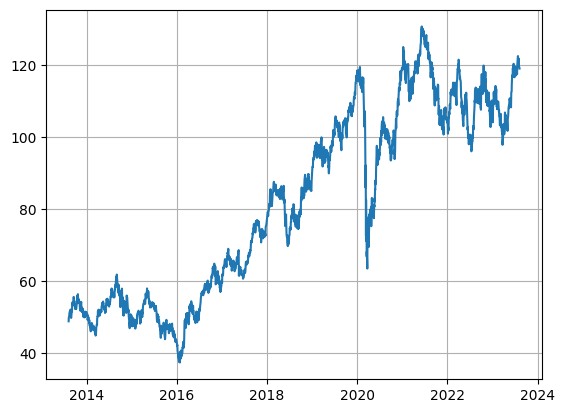

In [455]:
plt.plot(df_fechamento_pontos.index, df_fechamento_pontos.ultimo)
plt.grid(True)

## Decompondo a série

In [456]:
from statsmodels.tsa.seasonal import seasonal_decompose #lib para decompor série temporal
from statsmodels.tsa.stattools import acf, pacf #autocorrelação e autocorrelação parcial

In [457]:
df_fechamento_pontos.sort_index(inplace = True)

In [458]:
resultados = seasonal_decompose(df_fechamento_pontos, period = 7)

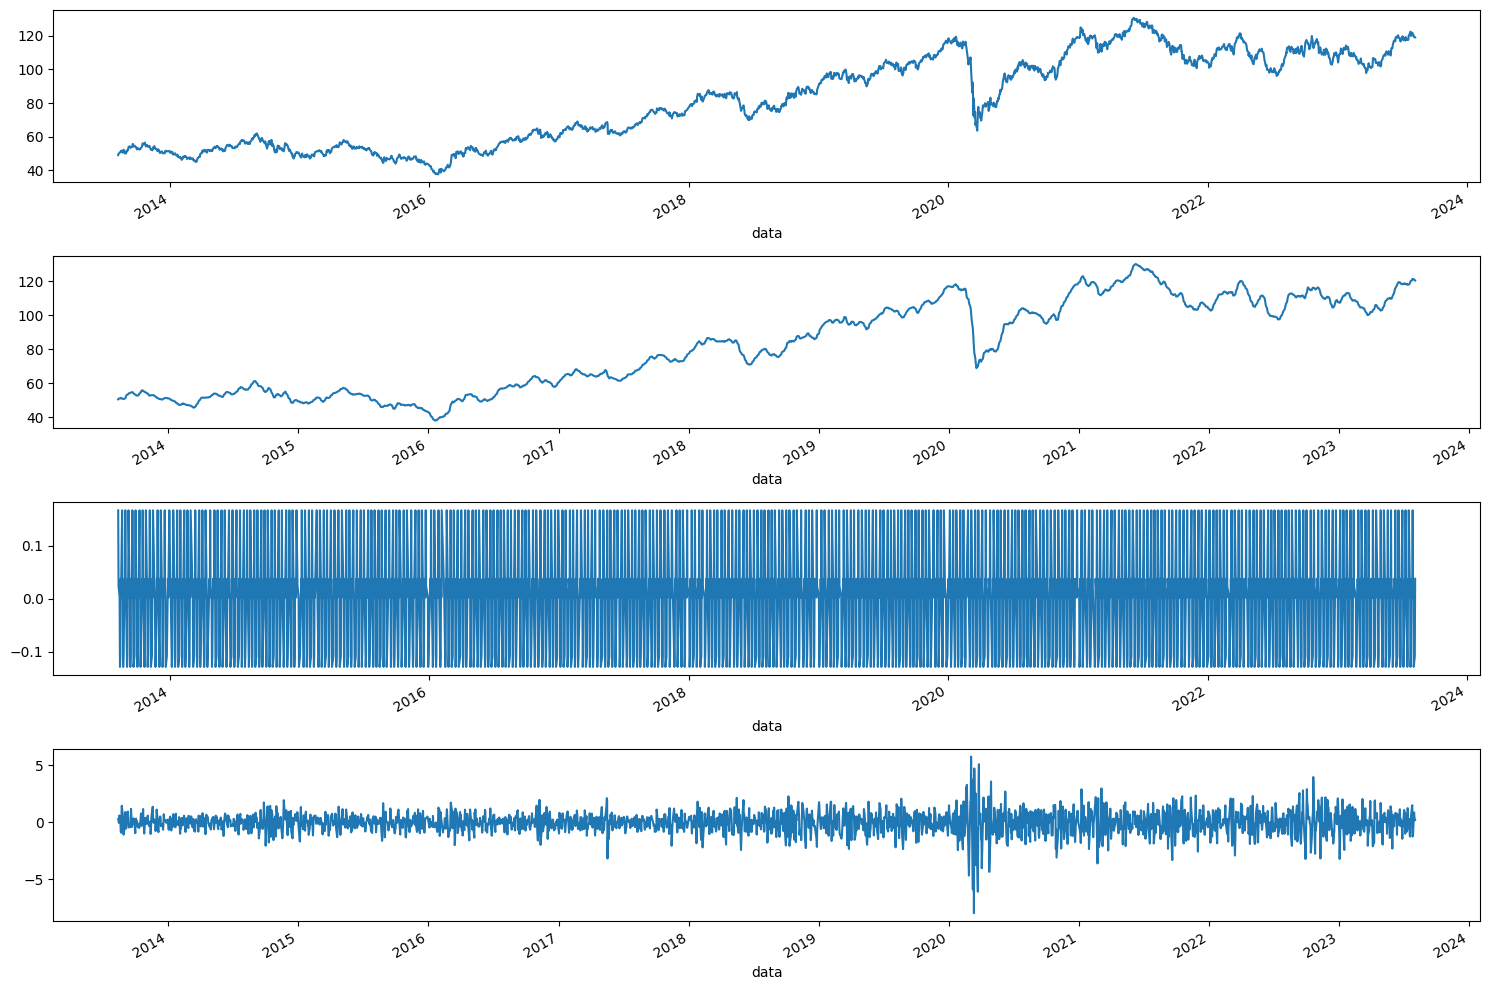

In [459]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize = (15, 10))
resultados.observed.plot(ax = ax1)
resultados.trend.plot(ax = ax2)
resultados.seasonal.plot(ax = ax3)
resultados.resid.plot(ax = ax4)
plt.tight_layout()

### ADF - Augmented Dickey-Fuller

>H0 - Hipótese Nula (não é estacionária)

>H1 - Hipótese Alternativa (rejeita a hipótese nula)

**p-valor <= 0.05 rejeitamos H0 com um nível de confiança de 95%**

In [460]:
from statsmodels.tsa.stattools import adfuller

In [461]:
X = df_fechamento_pontos.ultimo.values

result = adfuller(X)

print('Teste ADF')
print(f'Teste estatístico: {result[0]}')
print(f'P-valor: {result[1]}')
print(f'Valores críticos:')

for key, value in result[4].items():
    print(f'\t{key}: {value}')

Teste ADF
Teste estatístico: -1.112430950257849
P-valor: 0.7100892122627266
Valores críticos:
	1%: -3.4330013210750745
	5%: -2.8627113331035243
	10%: -2.567393547066656


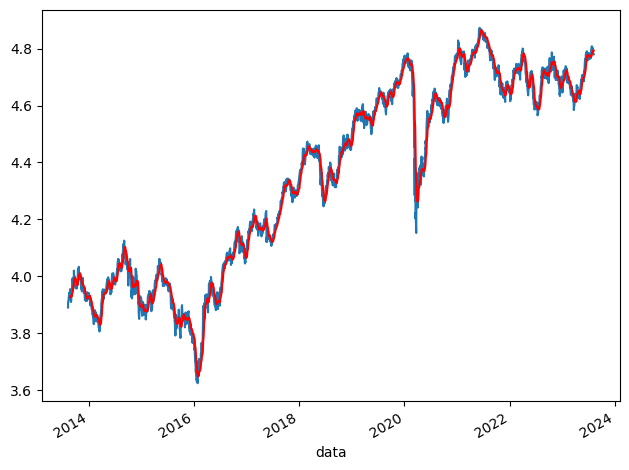

In [465]:
ma = df_fechamento_pontos.rolling(12).mean()

f, ax = plt.subplots()

df_fechamento_pontos.plot(ax = ax, legend = False)
ma.plot(ax = ax, legend = False, color = 'r')
plt.tight_layout()

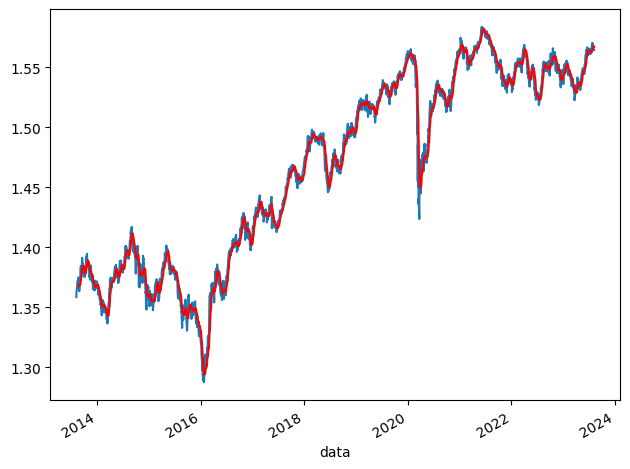

In [467]:
df_fechamento_pontos_log = np.log(df_fechamento_pontos)
ma_log = df_fechamento_pontos_log.rolling(12).mean()

f, ax = plt.subplots()
df_fechamento_pontos_log.plot(ax = ax, legend = False)
ma_log.plot(ax = ax, legend = False, color = 'r')
plt.tight_layout()

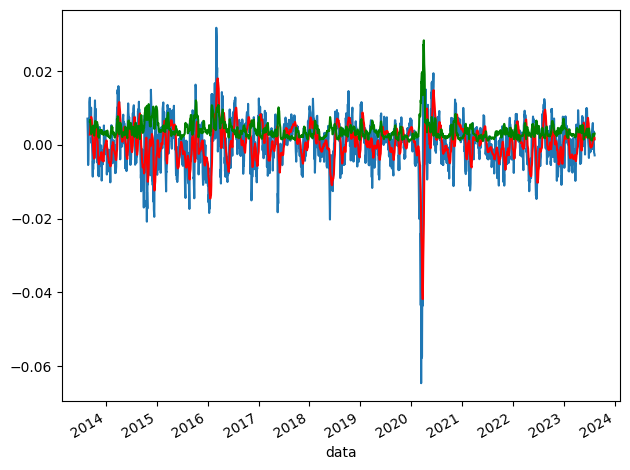

In [468]:
df_fechamento_pontos_s = (df_fechamento_pontos_log - ma_log).dropna()
ma_s = df_fechamento_pontos_s.rolling(12).mean()
std_s = df_fechamento_pontos_s.rolling(12).std()

f, ax = plt.subplots()
df_fechamento_pontos_s.plot(ax = ax, legend = False)
ma_s.plot(ax = ax, legend = False, color = 'r')
std_s.plot(ax = ax, legend = False, color = 'g')
plt.tight_layout()

In [469]:
X_s = df_fechamento_pontos_s.ultimo.values

result_s = adfuller(X_s)

print('Teste ADF')
print(f'Teste estatístico: {result_s[0]}')
print(f'P-valor: {result_s[1]}')
print(f'Valores críticos:')

for key, value in result_s[4].items():
    print(f'\t{key}: {value}')

Teste ADF
Teste estatístico: -12.886769415910104
P-valor: 4.536659377409146e-24
Valores críticos:
	1%: -3.433013198647963
	5%: -2.862716578179761
	10%: -2.5673963396253145


Teste ADF
Teste estatístico: -16.00747336916896
P-valor: 6.410350625348673e-29
Valores críticos:
	1%: -3.4330328659222165
	5%: -2.8627252631029694
	10%: -2.5674009636186508


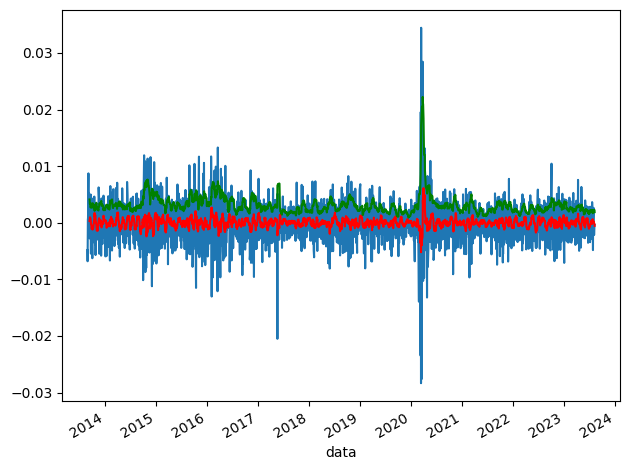

In [470]:
df_diff = df_fechamento_pontos_s.diff(1)
ma_diff = df_diff.rolling(12).mean()
std_diff = df_diff.rolling(12).std()

f, ax = plt.subplots()
df_diff.plot(ax = ax, legend = False)
ma_diff.plot(ax = ax, legend = False, color = 'r')
std_diff.plot(ax = ax, legend = False, color = 'g')
plt.tight_layout()

X_diff = df_diff.ultimo.dropna().values

result_diff = adfuller(X_diff)

print('Teste ADF')
print(f'Teste estatístico: {result_diff[0]}')
print(f'P-valor: {result_diff[1]}')
print(f'Valores críticos:')

for key, value in result_diff[4].items():
    print(f'\t{key}: {value}')

## ARIMA

In [471]:
lag_acf = acf(df_diff.dropna(), nlags = 25) #trabalhando na base mensal
lag_pacf = pacf(df_diff.dropna(), nlags = 25)

### 5% ACF

##### 1.96 / sqrt(N - d) -> N (número de pontos da base), d (número de vezes que diferenciamos a base)

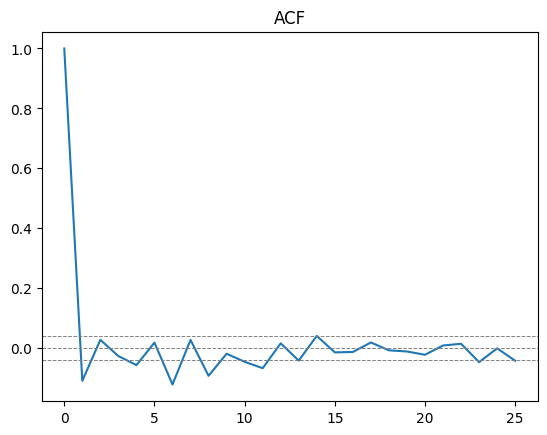

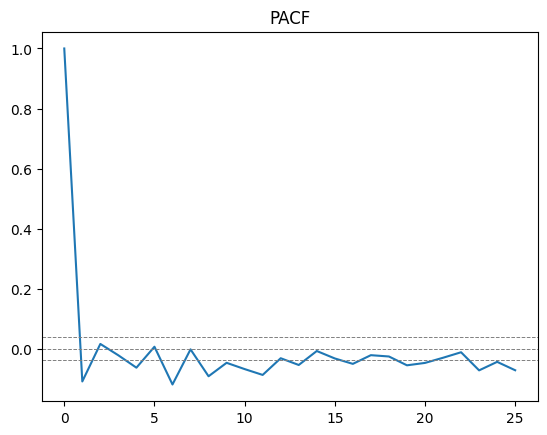

In [472]:
plt.plot(lag_acf)
plt.axhline(y = -1.96 / (np.sqrt(len(df_diff) -1)), linestyle = '--', color = 'gray', linewidth = 0.7)
plt.axhline(y = 0, linestyle = '--', color = 'gray', linewidth = 0.7)
plt.axhline(y = 1.96 / (np.sqrt(len(df_diff) -1)), linestyle = '--', color = 'gray', linewidth = 0.7)

plt.title('ACF')
plt.show()

plt.plot(lag_pacf)
plt.axhline(y = -1.96 / (np.sqrt(len(df_diff) -1)), linestyle = '--', color = 'gray', linewidth = 0.7)
plt.axhline(y = 0, linestyle = '--', color = 'gray', linewidth = 0.7)
plt.axhline(y = 1.96 / (np.sqrt(len(df_diff) -1)), linestyle = '--', color = 'gray', linewidth = 0.7)

plt.title('PACF')
plt.show()

In [473]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

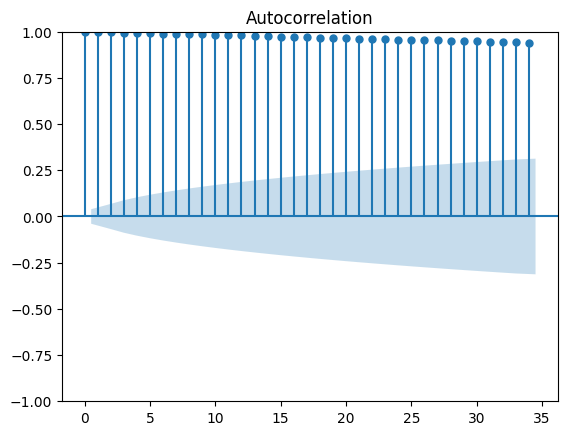

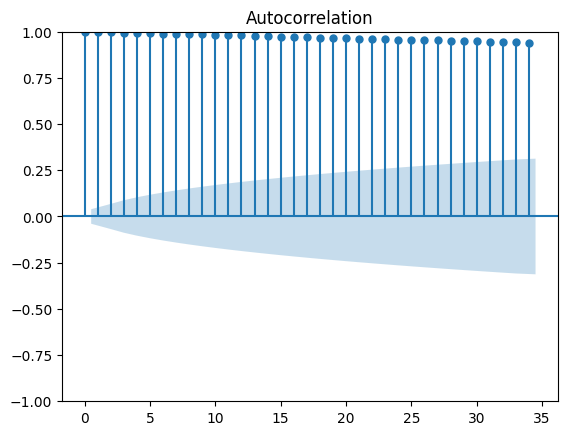

In [474]:
plot_acf(df_fechamento_pontos.values)

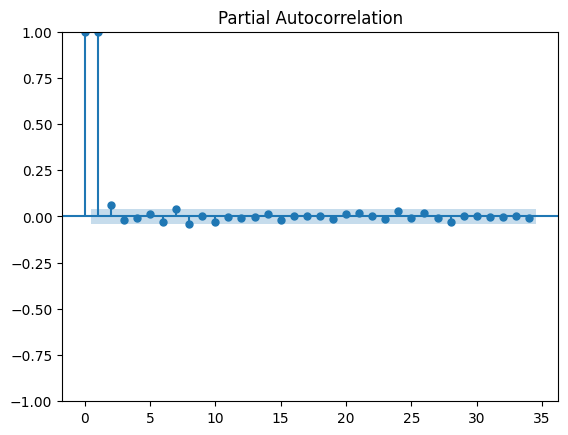

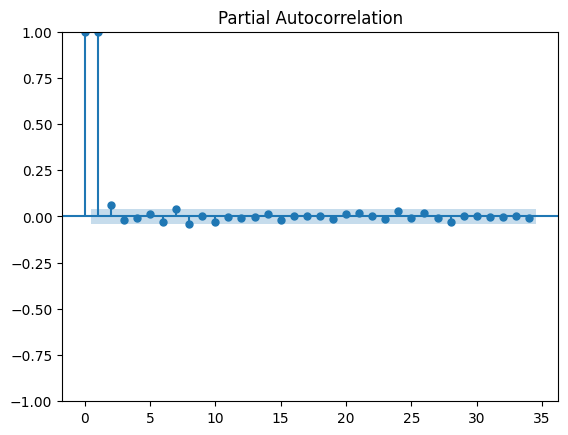

In [475]:
plot_pacf(df_fechamento_pontos.values)

## Modelando

In [477]:
df.reset_index(inplace = True)
df

,data,ultimo,abertura,maxima,minima,volume,variacao
0,2023-08-08,119.090,119.378,119.553,117.492,10.25,-0.24
1,2023-08-07,119.380,119.509,120.104,118.894,8.73,-0.11
2,2023-08-04,119.508,120.586,121.442,119.215,15.07,-0.89
3,2023-08-03,120.586,120.859,122.619,120.365,13.03,-0.23
4,2023-08-02,120.859,121.249,121.252,119.798,10.57,-0.32
...,...,...,...,...,...,...,...
2472,2013-08-14,50.896,50.594,51.364,50.414,11.27,0.58
2473,2013-08-13,50.601,50.299,50.734,50.040,6.51,0.60
2474,2013-08-12,50.299,49.878,51.380,49.878,7.04,0.85
2475,2013-08-09,49.875,48.949,50.001,48.836,6.32,1.93


In [478]:
df = df.rename(columns = {'data': 'ds', 'ultimo': 'y'})
df

,ds,y,abertura,maxima,minima,volume,variacao
0,2023-08-08,119.090,119.378,119.553,117.492,10.25,-0.24
1,2023-08-07,119.380,119.509,120.104,118.894,8.73,-0.11
2,2023-08-04,119.508,120.586,121.442,119.215,15.07,-0.89
3,2023-08-03,120.586,120.859,122.619,120.365,13.03,-0.23
4,2023-08-02,120.859,121.249,121.252,119.798,10.57,-0.32
...,...,...,...,...,...,...,...
2472,2013-08-14,50.896,50.594,51.364,50.414,11.27,0.58
2473,2013-08-13,50.601,50.299,50.734,50.040,6.51,0.60
2474,2013-08-12,50.299,49.878,51.380,49.878,7.04,0.85
2475,2013-08-09,49.875,48.949,50.001,48.836,6.32,1.93


In [485]:
treino = df.loc[df['ds'] < '2023-05-01'] #dados de treino
valid = df.loc[(df['ds'] >= '2023-05-01') & (df['ds'] < '2023-08-01')] #dados de validação (3 meses), quanto maior o período de predição, maior a largura de banda (maior o erro)
h = valid['ds'].nunique() #datas distintas no intervalo (90 dias)

In [486]:
h

64

### Modelo baseline

### Modelo baseline com sazonalidade

### Modelo baseline com sazonalidade e média móvel

### Modelo ARIMA